# Greenness (gcc) Predictions:

In [1]:
# importing required python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
import matplotlib.backends.backend_pdf
from matplotlib.dates import DayLocator, MonthLocator
from matplotlib.ticker import MaxNLocator
from datetime import date
import datetime
import pickle
# Create a pdf to save all the plots
pdf = matplotlib.backends.backend_pdf.PdfPages("PEG_RFR0_gcc_predictions_result_plots.pdf")

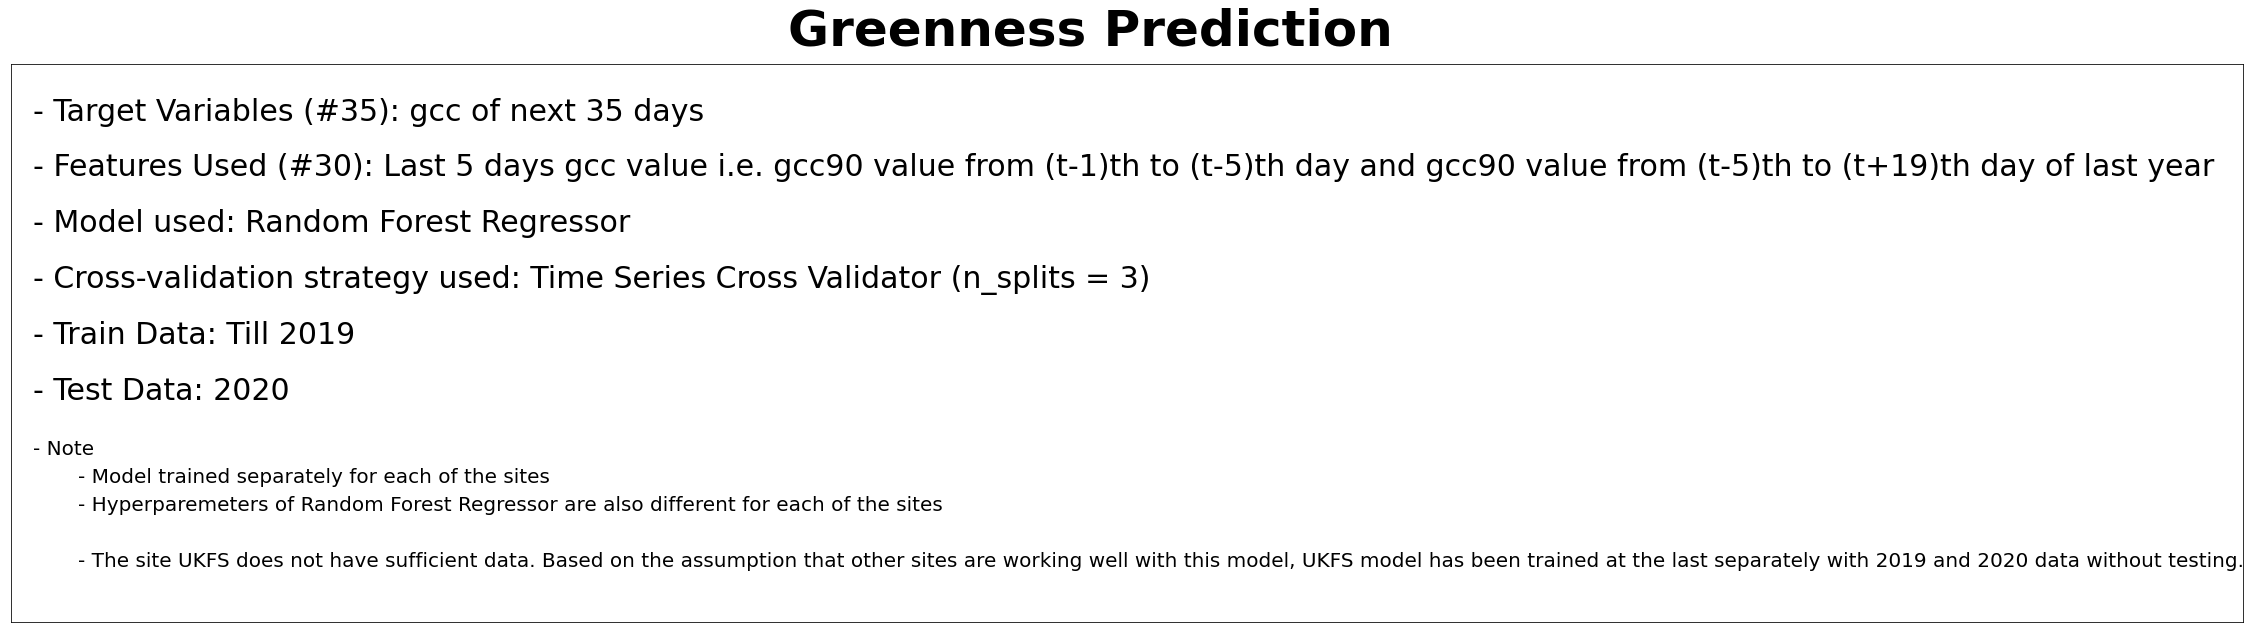

In [2]:
fig = plt.figure(figsize=(40,10))
fig.suptitle('Greenness Prediction', fontsize = 50, fontweight='bold')
#ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.90)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.text(0.01, 0.9, '- Target Variables (#35): gcc of next 35 days', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.8, '- Features Used (#30): Last 5 days gcc value i.e. gcc90 value from (t-1)th to (t-5)th day and gcc90 value from (t-5)th to (t+19)th day of last year', 
         fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.7, '- Model used: Random Forest Regressor', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.6, '- Cross-validation strategy used: Time Series Cross Validator (n_splits = 3)', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.5, '- Train Data: Till 2019', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.4, '- Test Data: 2020', fontsize = 30, horizontalalignment = 'left')
plt.text(0.01, 0.3, '- Note', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.25, '- Model trained separately for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.2, '- Hyperparemeters of Random Forest Regressor are also different for each of the sites', fontsize = 20, horizontalalignment = 'left')
plt.text(0.03, 0.1, '- The site UKFS does not have sufficient data. Based on the assumption that other sites are working well with this model, UKFS model has been trained at the last separately with 2019 and 2020 data without testing.', fontsize = 20, horizontalalignment = 'left')
pdf.savefig()

## Data Preparation

In [3]:
# Importing the input dataset
url = "https://raw.githubusercontent.com/genophenoenvo/neon-datasets/main/pheno_images/gcc_weather.csv"
dataset = pd.read_csv(url)
print("Shape of imported dataset:" + str(dataset.shape))
print("\nColumns of imported dataset:")
print(dataset.columns)

Shape of imported dataset:(12496, 8)

Columns of imported dataset:
Index(['time', 'siteID', 'gcc_90', 'gcc_sd', 'radiation', 'max_temp',
       'min_temp', 'precip'],
      dtype='object')


In [4]:
# Creating columns year, month, day and setting the time as index to use 'shift' funtion() 
dataset['time'] = pd.to_datetime(dataset['time'])
dataset['year'] = pd.DatetimeIndex(dataset['time']).year
dataset['month'] = pd.DatetimeIndex(dataset['time']).month
dataset['day'] = pd.DatetimeIndex(dataset['time']).day
dataset['year_month']= dataset['year'].map(str) + "-" + dataset['month'].map(str)
dataset = dataset.set_index("time")

In [5]:
# Selecting the required columns: siteID and gcc90 and date related columns
gcc_data = dataset[["siteID", "gcc_90", "year", "month", "day", "year_month"]]
print("Shape:" + str(gcc_data.shape))
site_list = gcc_data["siteID"].unique()
print("Sites:")
print(site_list)

Shape:(12496, 6)
Sites:
['HARV' 'BART' 'SCBI' 'STEI' 'UKFS' 'GRSM' 'DELA' 'CLBJ']


In [6]:
#Create dataframes for each of the sites and added those in a list 'site_data'
gcc_data_by_site = gcc_data.groupby("siteID")
site_data = []
for i in range(0,8):
    site_data.append(gcc_data_by_site.get_group(site_list[i]))

In [7]:
#Creating features by using shift() function
input_features = []
target_variables = ['gcc_90']
for k in range(0,8):
    for i in range(1,36):    # Creating 35 target variables
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        if(k == 0):
            target_variables.append(col_name_ahead)
        site_data[k].loc[:,col_name_ahead] = site_data[k].loc[:,"gcc_90"].shift(-i)
    for i in range(1,6):     #Creating features columns for last 5 days
        col_name = "gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name)
        site_data[k].loc[:,col_name] = site_data[k].loc[:,"gcc_90"].shift(i)
    for i in range(1,6):     #Creating features columns for last 5 days from last year
        col_name_last_year = "last_year_gcc_90_(t-"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year)
        site_data[k].loc[:,col_name_last_year] = site_data[k].loc[:,"gcc_90"].shift(i+365)
    for i in range(0,20):     #Creating features columns for t to (t+19) days from last year
        col_name_last_year_ahead = "last_year_gcc_90_(t+"+str(i)+")"
        if(k == 0):
            input_features.append(col_name_last_year_ahead)
        site_data[k].loc[:,col_name_last_year_ahead] = site_data[k].loc[:,"gcc_90"].shift(365-i)

C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
print("Columns in each of the site's dataframe:")
print(site_data[0].columns)

Columns in each of the site's dataframe:
Index(['siteID', 'gcc_90', 'year', 'month', 'day', 'year_month',
       'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)',
       'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)',
       'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)',
       'gcc_90_(t+13)', 'gcc_90_(t+14)', 'gcc_90_(t+15)', 'gcc_90_(t+16)',
       'gcc_90_(t+17)', 'gcc_90_(t+18)', 'gcc_90_(t+19)', 'gcc_90_(t+20)',
       'gcc_90_(t+21)', 'gcc_90_(t+22)', 'gcc_90_(t+23)', 'gcc_90_(t+24)',
       'gcc_90_(t+25)', 'gcc_90_(t+26)', 'gcc_90_(t+27)', 'gcc_90_(t+28)',
       'gcc_90_(t+29)', 'gcc_90_(t+30)', 'gcc_90_(t+31)', 'gcc_90_(t+32)',
       'gcc_90_(t+33)', 'gcc_90_(t+34)', 'gcc_90_(t+35)', 'gcc_90_(t-1)',
       'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)',
       'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)',
       'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)',
       'last_year_gcc_90_(t-5)', 'last_y

In [9]:
print("Input Features:\n" + str(input_features))
print("\nTarget Variables:\n" + str(target_variables))

Input Features:
['gcc_90_(t-1)', 'gcc_90_(t-2)', 'gcc_90_(t-3)', 'gcc_90_(t-4)', 'gcc_90_(t-5)', 'last_year_gcc_90_(t-1)', 'last_year_gcc_90_(t-2)', 'last_year_gcc_90_(t-3)', 'last_year_gcc_90_(t-4)', 'last_year_gcc_90_(t-5)', 'last_year_gcc_90_(t+0)', 'last_year_gcc_90_(t+1)', 'last_year_gcc_90_(t+2)', 'last_year_gcc_90_(t+3)', 'last_year_gcc_90_(t+4)', 'last_year_gcc_90_(t+5)', 'last_year_gcc_90_(t+6)', 'last_year_gcc_90_(t+7)', 'last_year_gcc_90_(t+8)', 'last_year_gcc_90_(t+9)', 'last_year_gcc_90_(t+10)', 'last_year_gcc_90_(t+11)', 'last_year_gcc_90_(t+12)', 'last_year_gcc_90_(t+13)', 'last_year_gcc_90_(t+14)', 'last_year_gcc_90_(t+15)', 'last_year_gcc_90_(t+16)', 'last_year_gcc_90_(t+17)', 'last_year_gcc_90_(t+18)', 'last_year_gcc_90_(t+19)']

Target Variables:
['gcc_90', 'gcc_90_(t+1)', 'gcc_90_(t+2)', 'gcc_90_(t+3)', 'gcc_90_(t+4)', 'gcc_90_(t+5)', 'gcc_90_(t+6)', 'gcc_90_(t+7)', 'gcc_90_(t+8)', 'gcc_90_(t+9)', 'gcc_90_(t+10)', 'gcc_90_(t+11)', 'gcc_90_(t+12)', 'gcc_90_(t+13)', '

In [10]:
# Calculating baseline gcc_90 for comparison (baseline gcc_90 = average of last 3 years gcc_90 value)
for k in range(0,8):
    df =  site_data[k].copy()
    
    df.drop(pd.Timestamp("2020-02-29"), inplace = True, errors = 'ignore')
    
    baseline_df = df[["siteID"]]
    avg = pd.DataFrame()
    
    avg["ly_1"] = df.loc[:, "gcc_90"].shift(365)
    avg["ly_2"] = df.loc[:, "gcc_90"].shift(365*2)
    avg["ly_3"] = df.loc[:, "gcc_90"].shift(365*3)
    avg["mean"] = avg.mean(axis = 1, skipna = True)
    baseline_df["baseline_gcc_90"] = avg["mean"]
    
    for i in range(1,35):
        baseline_col_name_ahead = "baseline_gcc_90_(t+"+str(i)+")"
        col_name_ahead = "gcc_90_(t+"+str(i)+")"
        avg = pd.DataFrame()
        avg["ly_1"] = df.loc[:, col_name_ahead].shift(365)
        avg["ly_2"] = df.loc[:, col_name_ahead].shift(365*2)
        avg["ly_3"] = df.loc[:, col_name_ahead].shift(365*3)
        avg["mean"] = avg.mean(axis = 1, skipna = True)
        baseline_df[baseline_col_name_ahead] = avg["mean"]
    
    baseline_df.drop("siteID", inplace = True, axis =1)
    site_data[k] = site_data[k].join(baseline_df, how ='outer')

<ipython-input-10-1f838476dbc7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df["baseline_gcc_90"] = avg["mean"]
<ipython-input-10-1f838476dbc7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  baseline_df[baseline_col_name_ahead] = avg["mean"]
C:\Users\palde\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [11]:
# Keeping current year data aside to make predictions later after the model being trained.
current_year_data = []
for k in range(0,8):
    current_year_data.append(site_data[k].loc['2021', :].dropna(subset = input_features))

In [12]:
#drop missing values
for k in range(0,8):
    site_data[k].dropna(subset = input_features + target_variables, inplace = True)

In [13]:
# data count for each year after dropping missing values
data_count = pd.DataFrame(index = [2016, 2017, 2018, 2019, 2020, 2021])
for k in range(0,8):
    data_count[site_list[k]] =  site_data[k].groupby("year").count().iloc[:, 1]
data_count

,HARV,BART,SCBI,STEI,UKFS,GRSM,DELA,CLBJ
2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017,NaN,8.0,1.0,NaN,NaN,NaN,11.0,NaN
2018,257.0,135.0,110.0,28.0,NaN,216.0,281.0,20.0
2019,228.0,152.0,171.0,283.0,21.0,192.0,321.0,307.0
2020,199.0,189.0,232.0,300.0,189.0,238.0,252.0,274.0
2021,25.0,47.0,47.0,47.0,NaN,46.0,26.0,47.0


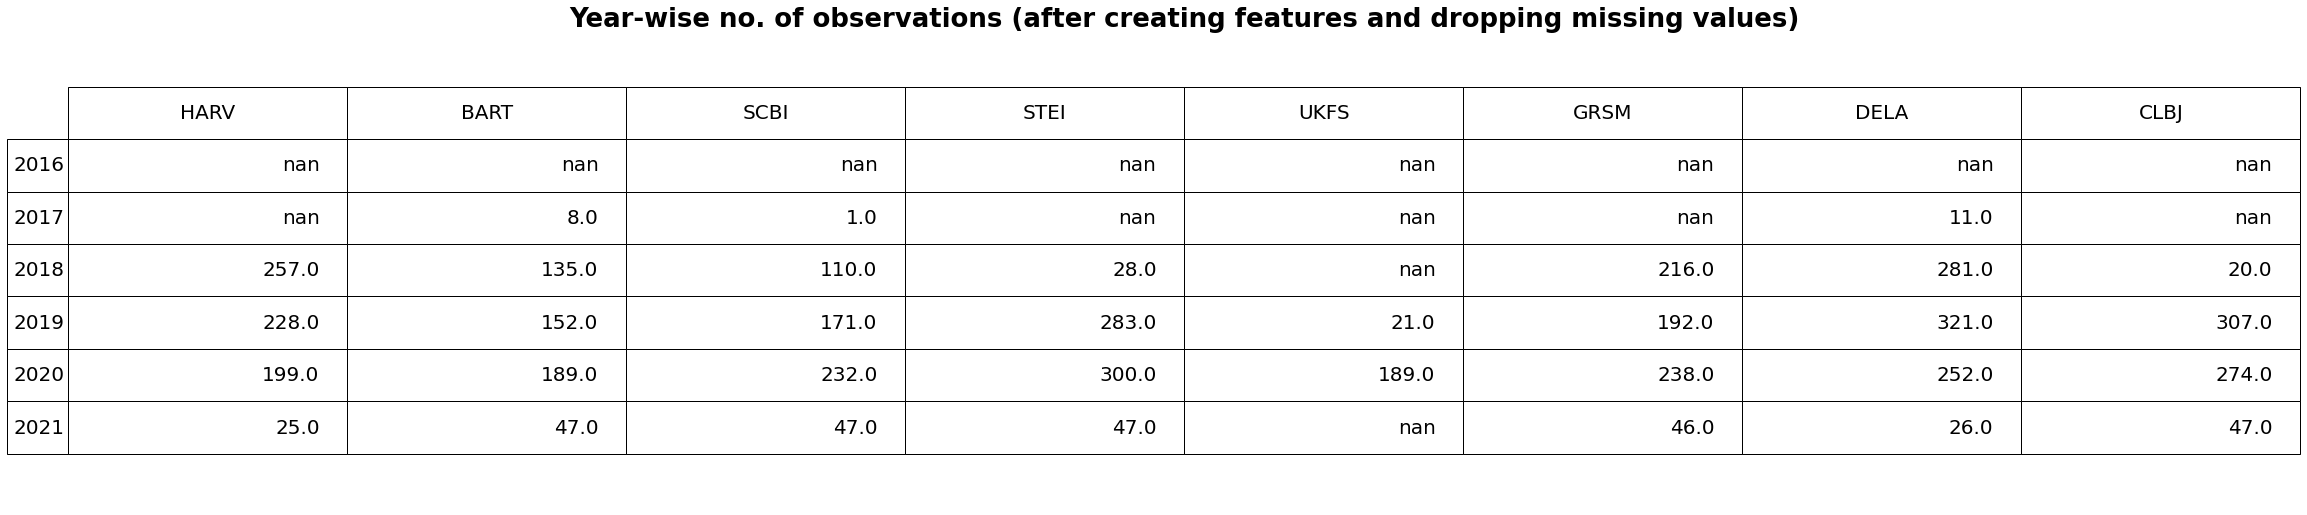

In [14]:
plt.figure(figsize=(40,8))
table = plt.table(np.array(data_count), rowLabels = [2016, 2017, 2018, 2019, 2020, 2021],
                      colLabels = site_list,
                      loc='center')
table.set_fontsize(20)
table.scale(1,4)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)
plt.title("Year-wise no. of observations (after creating features and dropping missing values)", fontsize = 26, fontweight = 'bold')
plt.subplots_adjust(top=0.950)
#plt.subplots_adjust(bottom=0.10)
fig.tight_layout()
pdf.savefig()

## Training Using Random Forest Regressor
#### Training is done for each of the sites except UKFS as suffucient data is not available for training and testing. UKFS is trained later by using all the data based on the assumption the performance would be same as that of other sites. No testing is done for UKFS  

In [15]:
#Train the models
best_models = []
overall_rmse_score = []
overall_r2_score = []
target_variable_wise_score = []
true_results = []
predicted_results = []

for k in range(0,8):
    print("\n" + str(site_list[k]) + ":\n")
    X_train = site_data[k][site_data[k].columns.intersection(input_features)].loc[:'2019', :]
    Y_train = site_data[k][site_data[k].columns.intersection(target_variables)].loc[:'2019', :]
    X_test = site_data[k][site_data[k].columns.intersection(input_features)].loc['2020', :]
    Y_test = site_data[k][site_data[k].columns.intersection(target_variables)].loc['2020', :]
    print("Shape of X_train:" + str(X_train.shape))
    print("Shape of X_train:" + str(Y_train.shape))
    print("Shape of X_train:" + str(X_test.shape))
    print("Shape of X_train:" + str(Y_test.shape))
    
    model = RandomForestRegressor(random_state = 0)
    param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

    tscv = TimeSeriesSplit(n_splits = 3)
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
    gsearch.fit(X_train, Y_train)
    
    best_score = gsearch.best_score_
    best_model = gsearch.best_estimator_
    
    best_models.append(best_model)
    print("RMSE of Training Data: " + str(best_score))
    print("Model:" + str(best_model))
    
    Y_pred = best_model.predict(X_test)
    Y_true = np.array(Y_test)
    
    predicted_results.append(Y_pred)
    true_results.append(Y_true)
    
    explained_variance = metrics.explained_variance_score(Y_true, Y_pred)
    mse = metrics.mean_squared_error(Y_true, Y_pred)
    rmse = np.sqrt(mse)
    r2 = metrics.r2_score(Y_true, Y_pred)
    
    overall_rmse_score.append(rmse)
    overall_r2_score.append(r2)
    
    print("explained_variance: " + str(explained_variance))
    print("RMSE: "+ str(rmse))
    print("R2: "+ str(r2))
    print("------------------------------------------------------------------------")


HARV:

Shape of X_train:(485, 30)
Shape of X_train:(485, 36)
Shape of X_train:(199, 30)
Shape of X_train:(199, 36)
RMSE of Training Data: -0.0211615361608163
Model:RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=10,
                      random_state=0)
explained_variance: 0.9586852037637313
RMSE: 0.008792856160318545
R2: 0.9585395045146795
------------------------------------------------------------------------

BART:

Shape of X_train:(295, 30)
Shape of X_train:(295, 36)
Shape of X_train:(189, 30)
Shape of X_train:(189, 36)
RMSE of Training Data: -0.015433956709280086
Model:RandomForestRegressor(max_depth=8, n_estimators=20, random_state=0)
explained_variance: 0.962381375689235
RMSE: 0.008694223453104763
R2: 0.9610402504058031
------------------------------------------------------------------------

SCBI:

Shape of X_train:(282, 30)
Shape of X_train:(282, 36)
Shape of X_train:(232, 30)
Shape of X_train:(232, 36)
RMSE of Training Data: -0.01631471864457852
Model:

## Performance Evaluation

In [16]:
# Overall performance evaluation plot
site_list_modified = list(site_list[:4]) + list(site_list[5:])
overall_rmse_score_modified = list(overall_rmse_score[:4]) + list(overall_rmse_score[5:])
overall_r2_score_modified = list(overall_r2_score[:4]) + list(overall_r2_score[5:])

fig, ax = plt.subplots(1, 2, figsize = (40, 12), dpi=80)
fig.suptitle("Site- wise Overall Performance Evaluation", fontsize=30, fontweight='bold')
ax[0].tick_params(axis='both', which='major', labelsize=30)
ax[0].set_ylabel("RMSE", fontsize = 26)
ax[0].set_ylim(0.005, 0.020)
ax[0].set_title("Root Mean Squared Error", fontsize = 32) 
ax[0].plot(site_list_modified, overall_rmse_score_modified, color = 'black', marker='o')
ax[0].yaxis.grid()

ax[1].set_ylabel("R-Squared Score", fontsize = 30)
ax[1].set_title("R-Squared Score", fontsize = 32)
ax[1].set_ylim(0.60, 1.00)
ax[1].plot(site_list_modified, overall_r2_score_modified, color = 'black', marker='o')
#ax[1].axhline(y=0.85, linestyle = "--")
ax[1].tick_params(axis='both', which='major', labelsize = 30)
ax[1].yaxis.grid()
pdf.savefig()
plt.close()

In [17]:
# Plot target variable wise RMSE
fig, ax = plt.subplots(4, 2, figsize = (40, 50), dpi = 140)
ax = ax.flatten()
fig.suptitle("Target Variable Wise RMSE", fontsize=26, fontweight='bold')

for k in range(0,8):
    rmse_dict = {"Target":[],"RMSE":[]}
    Y_pred = predicted_results[k]
    Y_true = true_results[k]
    for i in range(0,36):
        #explained_variance = metrics.explained_variance_score(Y_true[:, i], Y_pred[:, i])
        mse = metrics.mean_squared_error(Y_true[:, i], Y_pred[:, i])
        rmse = np.sqrt(mse)
        rmse_dict["Target"].append(i+1)
        rmse_dict["RMSE"].append(rmse)
        
    ax[k].set_title(site_list[k], fontsize=32)
    #ax[k].text(0, 0.046, str(best_models[k]), fontsize=20)
    ax[k].plot(rmse_dict["Target"], rmse_dict['RMSE'], color = 'black', lw=1, marker = 'o')
    ax[k].set_ylim(0.0025,0.025)
    ax[k].set_ylabel("RMSE", fontsize = 30)
    ax[k].set_xlabel("Target Variables (Today and Next 35 days)", fontsize=30) 
    ax[k].tick_params(axis='both', which='major', labelsize=30)
    
plt.subplots_adjust(top=0.95)
pdf.savefig()
plt.close()

In [18]:
# Create plot for Features Importance Across Different Sites
site_list_modified = list(site_list[:4]) + list(site_list[5:])
best_models_modified = list(best_models[:4]) + list(best_models[5:])
best_models_modified
fig, ax = plt.subplots(7, 1, figsize = (40, 120), gridspec_kw={'width_ratios': [10]}, dpi = 100)
ax = ax.flatten()
fig.suptitle("Feature Importances", fontsize=26, fontweight='bold')
for k in range(0,7):
    imp = best_models_modified[k].feature_importances_
    indices = np.argsort(imp)
    #features = X_train.columns
    ax[k].set_title(site_list_modified[k], fontsize=34)
    ax[k].barh(range(len(indices)), imp[indices], color = 'gray', align='center')
    ax[k].set_yticks(range(len(indices)))
    ax[k].set_yticklabels([input_features[i] for i in indices])
    ax[k].set_xlabel("Relative Importance", fontsize = 30) 
    ax[k].tick_params(axis='both', which='major', labelsize=30)
    ax[k].set_xlim(0.0, 0.6)
plt.subplots_adjust(top=0.98)
pdf.savefig()
plt.close()

In [19]:
# Create dataframe for testing
predicted_site_data = []
for k in range(0,8):
    predicted_site_data.append(site_data[k].loc['2020', :])

In [20]:
for k in range(0,8):
    Y_pred = predicted_results[k]
    predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = "predicted_gcc_90", value = Y_pred[:, 0])
    for i in range(1,35):
        predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
        predicted_site_data[k].insert(loc = len(predicted_site_data[k].columns), column = predicted_col_name, 
                                      value = Y_pred[:, i])

##### Plotting Difference between true and predicted gcc_90

In [21]:
df = predicted_site_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [22]:
df = predicted_site_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [23]:
df = predicted_site_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [24]:
df = predicted_site_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [25]:
df = predicted_site_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [26]:
df = predicted_site_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [27]:
df = predicted_site_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

In [28]:
df = predicted_site_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("Difference between True and Predicted gcc_90 for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"] - df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o')
ax[0].set_title("Day: " + str(1), fontsize=20, fontweight='bold')
ax[0].set_ylim(-0.1,0.1)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=20, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name] - df[predicted_col_name], color = 'red', lw=1, marker = 'o')
    ax[i].set_ylim(-0.1,0.1)
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].set_ylabel("Difference between True and Predicted GCC")
    ax[i].set_xlabel("Date", fontsize = 20)   
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.975)
pdf.savefig()
plt.close()

##### Plotting True, vs. Predicted vs. Baseline gcc_90 (baseline gcc_90 is the average of last 3 years gcc_90)

In [29]:
df = predicted_site_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-29-3848d64a2f1a>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-29-3848d64a2f1a>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [30]:
df = predicted_site_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-30-918595c38872>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-30-918595c38872>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [31]:
df = predicted_site_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-31-3f2c731696fe>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-31-3f2c731696fe>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

<ipython-input-33-2f86afeafe32>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-2f86afeafe32>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-2f86afeafe32>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-2f86afeafe32>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

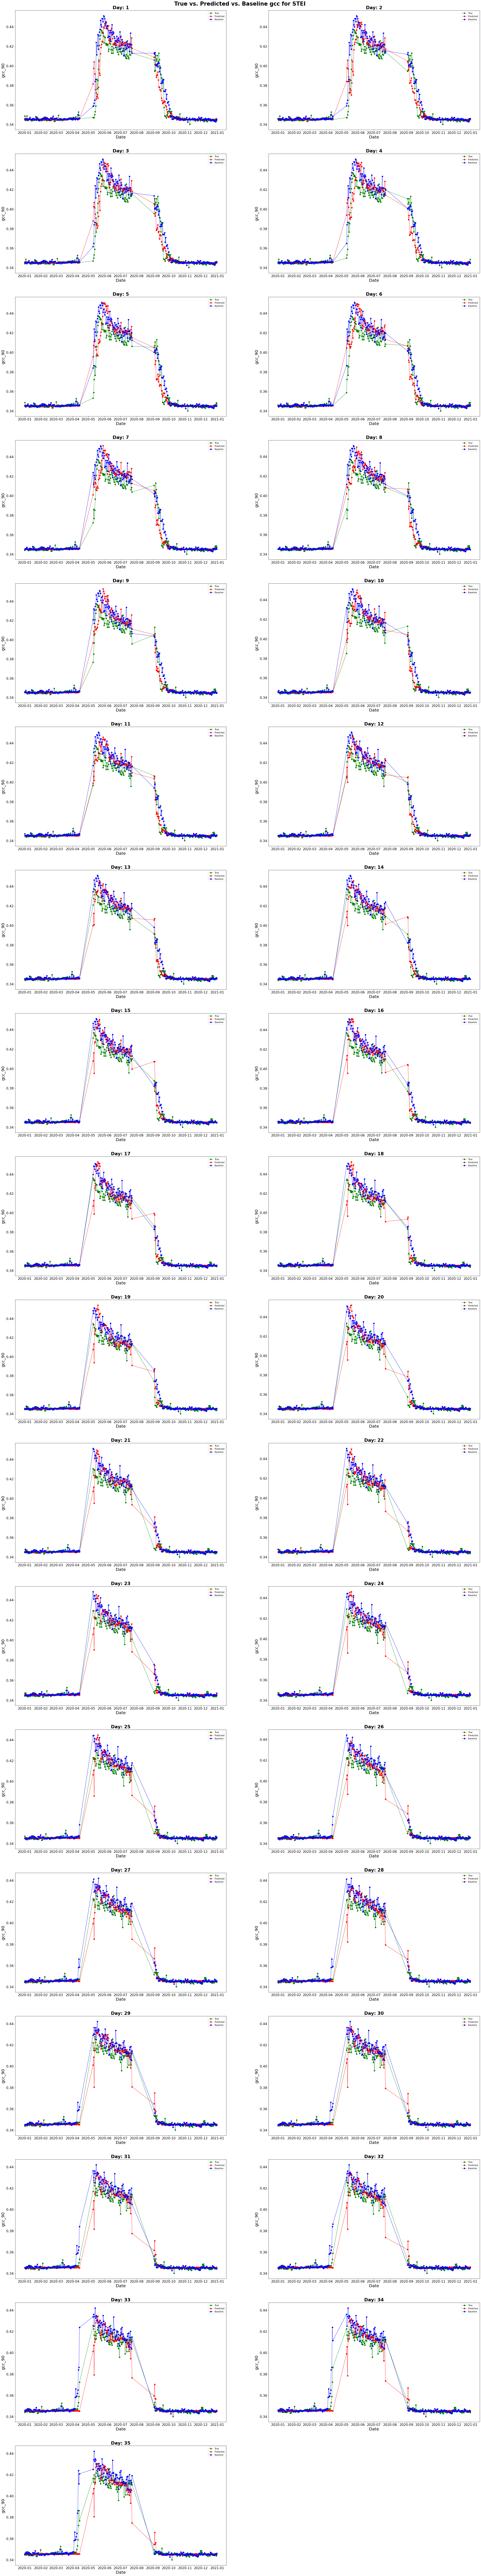

In [33]:
df = predicted_site_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()

In [32]:
df = predicted_site_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-32-72ae6bc1e656>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-32-72ae6bc1e656>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [33]:
df = predicted_site_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-33-44ff1d388fcf>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-33-44ff1d388fcf>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [34]:
df = predicted_site_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-34-c39360d27076>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-34-c39360d27076>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [35]:
df = predicted_site_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("True vs. Predicted vs. Baseline gcc for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["gcc_90"], color = 'green', lw=1, marker = 'o', label = "True")
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(MonthLocator())
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)
for i in range(1,35):
    true_col_name = "gcc_90_(t+"+str(i)+")"
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[true_col_name], color = 'green', lw = 1, marker = 'o', label = "True")
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(MonthLocator())
    #ax[i].xaxis.set_major_locator(MaxNLocator(13)) 
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-35-b1214a7f9f84>:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-35-b1214a7f9f84>:24: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

##### Comparing the predictions for 2021 with baseline gcc_90

In [36]:
current_year_predictions = []
for k in range(0,8):
    current_year_input = current_year_data[k][current_year_data[k].columns.intersection(input_features)]
    current_year_predictions.append(best_models[k].predict(current_year_input))

In [37]:
for k in range(0,8):
    predicted_result = current_year_predictions[k]
    current_year_data[k].insert(loc = len(current_year_data[k].columns), column = "predicted_gcc_90", value = predicted_result[:, 0])
    for i in range(1,35):
        predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
        current_year_data[k].insert(loc = len(current_year_data[k].columns), column = predicted_col_name, 
                                      value = predicted_result[:, i])

In [38]:
df = current_year_data[0]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 200))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[0], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-38-a77e19475b10>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-38-a77e19475b10>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-o

In [39]:
df = current_year_data[1]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 220))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[1], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-39-4d7cd2147a3b>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-39-4d7cd2147a3b>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-39-4d7cd2147a3b>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-39-4d7cd2147a3b>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [40]:
df = current_year_data[2]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[2], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-40-12cfd98a2d1c>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-40-12cfd98a2d1c>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [41]:
df = current_year_data[3]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[3], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-41-4fcfcd4ac6c1>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-41-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

<ipython-input-41-4fcfcd4ac6c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)


In [42]:
df = current_year_data[4]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[4], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-42-de6108eba3c1>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-42-de6108eba3c1>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [43]:
df = current_year_data[5]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[5], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-43-1d89a00e4e5e>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-43-1d89a00e4e5e>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [44]:
df = current_year_data[6]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[6], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-44-4eabbac577fc>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-44-4eabbac577fc>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [45]:
df = current_year_data[7]
df = df.reset_index()
fig, ax = plt.subplots(18, 2, figsize = (40, 240))
ax = ax.flatten()
fig.suptitle("2021 Predicted vs. Baseline gcc for "+ site_list[7], fontsize=26, fontweight='bold')
ax[0].plot(df["time"], df["predicted_gcc_90"], color = 'red', lw=1, marker = 'o', label = "Predicted")
ax[0].plot(df["time"], df["baseline_gcc_90"], color = 'blue', lw=1, marker = 'o', label = "Baseline")
ax[0].set_title("Day: " + str(1), fontsize = 22, fontweight='bold')
ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
ax[0].xaxis.set_major_locator(DayLocator())
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_xlabel("Date", fontsize = 20)
ax[0].set_ylabel("gcc_90", fontsize = 20)
ax[0].legend()
ax[0].tick_params(axis='both', which='major', labelsize=16)

for i in range(1,35):
    predicted_col_name = "predicted_gcc_90_(t+"+str(i)+")"
    baseline_col_name = "baseline_gcc_90_(t+"+str(i)+")"
    ax[i].set_title("Day: " + str(i+1), fontsize=22, fontweight='bold')
    ax[i].plot(df["time"], df[predicted_col_name], color = 'red', lw = 1, marker = 'o', label = "Predicted")
    ax[i].plot(df["time"], df[baseline_col_name], color = 'blue', lw = 1, marker = 'o', label = "Baseline")
    ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
    ax[i].set_ylabel("gcc_90")
    ax[i].xaxis.set_major_locator(DayLocator())
    ax[i].tick_params(axis='x', labelrotation = 45)
    ax[i].set_xlabel("Date", fontsize = 20)  
    ax[i].set_ylabel("gcc_90", fontsize = 20)
    ax[i].legend()
    ax[i].tick_params(axis='both', which='major', labelsize=16)
ax[34] = plt.gca()
ax[34].get_xaxis().set_visible(False)
ax[34].get_yaxis().set_visible(False)
plt.box(on=None)
plt.subplots_adjust(top=0.977)
pdf.savefig()
plt.close()

<ipython-input-45-448c69318039>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[i].set_yticks(np.arange(0.3, 0.5), 0.02)
<ipython-input-45-448c69318039>:23: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-on

In [46]:
pdf.close()

In [49]:
site_list

array(['HARV', 'BART', 'SCBI', 'STEI', 'UKFS', 'GRSM', 'DELA', 'CLBJ'],
      dtype=object)

In [50]:
best_models

[RandomForestRegressor(max_depth=6, max_features='sqrt', n_estimators=10,
                       random_state=0),
 RandomForestRegressor(max_depth=8, n_estimators=20, random_state=0),
 RandomForestRegressor(max_depth=8, n_estimators=10, random_state=0),
 RandomForestRegressor(max_depth=7, n_estimators=10, random_state=0),
 RandomForestRegressor(max_depth=6, max_features='log2', random_state=0),
 RandomForestRegressor(max_depth=8, n_estimators=10, random_state=0),
 RandomForestRegressor(max_depth=6, n_estimators=50, random_state=0),
 RandomForestRegressor(max_depth=12, max_features='sqrt', n_estimators=10,
                       random_state=0)]

### Train the site UKFS

In [51]:
UKFS_X_train = site_data[4][site_data[4].columns.intersection(input_features)]
UKFS_y_train = site_data[4][site_data[4].columns.intersection(target_variables)]

model = RandomForestRegressor(random_state = 0)
param_search = {
    'n_estimators': [10,20,50,100],
    'max_features': ['auto', 'sqrt','log2'],
    'max_depth': [i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits = 3)
gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = "neg_root_mean_squared_error")
gsearch.fit(UKFS_X_train, UKFS_y_train)
    
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
    
best_models[4] = best_model
print("RMSE of Training Data: " + str(best_score))
print("Model:" + str(best_model))

RMSE of Training Data: -0.010831156820124853
Model:RandomForestRegressor(max_depth=7, random_state=0)


### Save the models

In [52]:
for k in range(0,8):
    file_name = "model_"+site_list[k]+".pkl"
    pickle.dump(best_models[k], open(file_name, 'wb'))